![logo](../../../LogoLine_horizon_C3S.png)

<div class="alert alert-block alert-warning">
Please note that this repository is used for development and review, so quality assessments should be considered work in progress until they are merged into the main branch
</div>

# Historical accuracy of sea ice extent in the CMIP6 experiment [climate (projections)]-[model-performance]-[scientific-study]

Prouction date: 2024-05-31
Produced by: Timothy Williams, Nansen Environmental and Remote Sensing Center (NERSC)

## Quality assessment question
**How reliable are the historical estimates of the Arctic and Antarctic sea ice concentration and extent from the CMIP6 models?**

## Quality assessment statement
- Bearing in mind that sea ice concentration estimates from passive microwave observations themselves are quite uncertain, we find that the errors between them and the CMIP6 models in the historical experiment can have significant biases and also have quite a large spread, so should be treated with some caution.
- We find that the CMIP6 models generally underestimate the sea ice extent and area. Errors for the Antarctic are approximately double those in the Arctic. While the Arctic sea ice minima are generally quite accurate, the Arctic maxima are consistently underestimated, as are the Antarctic extrema.
- At the time of the Arctic minimum, there is a general underestimation in the pack ice, but an overestimation in the MIZ and near the coasts.
- At the time of the Arctic maximum, the concentration in the pack is relatively unbiased, but there are some areas where there is strong underestimation (Bering Sea, Sea of Okhotsk)and overestimation (Greenland Sea, Labrador Sea).
- Arctic December: one of the other CMIP6 quality assessments looks at projections of accessibility of Arctic shipping routes, where sea ice in December is particularly interesting. Therefore we also check the reliability of the December concentrations in the CMIP6 models. We find that the concentration in the pack is quite similar to the observations, although there is significant underestimation in Hudson Bay, and less pronounced underestimation in the Bering Sea. In later years, there is also slight underestimation off the Russian coast. The ice extent in the Greenland and Barents Sea is consistently overestimated.
- At the time of the Antarctic minimum, there is strong underestimation in the Weddell, Bellingshausen and Amundsen Seas, while south of the Pacific and Indian Oceans, there is less bias. However, there there is too little ice at the coast and too much away from it.
- At the time of the Antarctic maximum, there is in general too little ice everywhere, with the region away from the coast at longitude about 140W south of the Atlantic Ocean, and in the region south of the Indian Ocean having the most pronounced underestimation. The underestimation on those areas is also increasing with time, while the concentration from satellite is staying relatively constant in this month as well.
- These results are generally consistent with analyses from other authors - for the Arctic by the [SIMIP community (2020)](https://doi.org/10.1029/2019GL086749), [Davy and Outten (2020)](https://doi.org/10.1175/JCLI-D-19-0990.1), [Shu et al (2020)](https://doi.org/10.1029/2020GL087965), [Watts et al (2021)](https://doi.org/10.1175/JCLI-D-20-0491.1), [Henke et al (2023)](https://doi.org/10.1080/15230430.2023.2271592) and [Frankignoul et al (2024)](https://doi.org/10.1175/JCLI-D-23-0452.1); for the Antarctic by [Roach et al (2020)](https://doi.org/10.1029/2019GL086729), [Shu et al (2020)](https://doi.org/10.1029/2020GL087965), [Nie et al (2023)](https://doi.org/10.1029/2023GL105265) and [Li et al (2023)](https://doi.org/10.3390/rs15082048).
- We ourselves don't consider time series of the sea ice minima themselves, but only plot climatologies of the multi-model mean to see how the differences between the models and the observations are distributed spatially. However, this has been done by a few others, e.g. [Shu et al (2020)](https://doi.org/10.1029/2020GL087965), who found the observed Arctic September SIE declining trend between 1979 and 2014 is slightly underestimated in CMIP6 models, while the observed weak but significant upward trend of the Antarctic SIE is not captured.

## Methodology
We compare sea ice concentrations from the [CMIP6](https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cmip6?tab=overview) historical experiment with that obtained from [passive microwave satellite products from EUMETSAT OSI- SAF and ESA CCI](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-sea-ice-concentration?tab=overview).  Time series of the evaluation metrics Integrated Ice Edge Error (IIEE) ([Goessling et al, 2016](https://doi.org/10.1002/2015GL067232); [Henke et al, 2023)](https://doi.org/10.1080/15230430), bias in extent and area, and the RMSE in sea ice concentration are produced and plotted. All of these statistics are area-weighted averages. We consider all the CMIP6 models that output sea ice concentration in the historical experiment, but remove outliers by only plotting the interquartile limits (IQLs). Other authors have chosen different subsetting approaches - e.g. by scoring the models and only retaining the top-performing ones. We recommend users test as many models as possible, before deciding if a subset adequately represents the uncertainty for their application

Decadal climatologies for both the models and observations are also produced and compared, for the months March, September and December.

The analysis and results are organised in the following steps, which are detailed in the sections below:
1. [](climate_projections-cmip6_model-performance_q02:utility-code) Define some functions used in the analysis and visualisation.
2. [](climate_projections-cmip6_model-performance_q02:download-data) Run code to download the data.
3. [](climate_projections-cmip6_model-performance_q02:time-series) Plot some time series of the error metrics
4. [](climate_projections-cmip6_model-performance_q02:spatial-distribution)
  This section has maps of climatologies and their biases for the [](climate_projections-cmip6_model-performance_q02:arctic-min), [](climate_projections-cmip6_model-performance_q02:arctic-max), [](climate_projections-cmip6_model-performance_q02:antarctic-min), [](climate_projections-cmip6_model-performance_q02:antarctic-max). We also plot maps for the [](climate_projections-cmip6_model-performance_q02:arctic-december) since this was an interesting month for the climate projections.

## Analysis and Results

(climate_projections-cmip6_model-performance_q02:utility-code)=
### Section A: Utility code
This section defines some functions used in the analysis and visualisation.

#### Import required libraries

In [1]:
import datetime
import warnings
import calendar
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
from cmocean import cm

from c3s_eqc_automatic_quality_control import diagnostics, download, plot

plt.style.use("seaborn-v0_8-notebook")
warnings.filterwarnings("ignore", module="cf_xarray")

#### Set parameters
Set analysis time period, and the regions and models to analyse. Also define the concentration threshold for determining sea ice extent (we use 30% to be consistent with the ice edge product).

In [2]:
# Time
year_start = 1970
year_stop = 2019
assert year_start >= 1970 and year_stop <= 2019
assert not (year_start % 10 or (year_stop + 1) % 10)

# Sea Ice Concentration Threshold
sic_threshold = 30  # %

# Select masks
regions = ["northern_hemisphere", "southern_hemisphere"]
assert set(regions) <= {
    "northern_hemisphere",
    "southern_hemisphere",
}

# Choose CMIP6 historical models
models = [
    "access_cm2",
    "access_esm1_5",
    "cams_csm1_0",
    "canesm5",
    "canesm5_canoe",
    "cmcc_cm2_hr4",
    "cmcc_cm2_sr5",
    "cmcc_esm2",
    "cnrm_cm6_1",
    "cnrm_cm6_1_hr",
    "cnrm_esm2_1",
    "e3sm_1_0",
    "e3sm_1_1",
    "e3sm_1_1_eca",
    "ec_earth3_aerchem",
    "ec_earth3_cc",
    "ec_earth3_veg_lr",
    "fgoals_f3_l",
    "giss_e2_1_h",
    "hadgem3_gc31_ll",
    "hadgem3_gc31_mm",
    "inm_cm4_8",
    "inm_cm5_0",
    "ipsl_cm5a2_inca",
    "ipsl_cm6a_lr",
    "miroc6",
    "miroc_es2l",
    "mpi_esm1_2_hr",
    "mpi_esm1_2_lr",
    "mri_esm2_0",
    "nesm3",
    "norcpm1",
    "taiesm1",
    "ukesm1_0_ll",
]

#### Define requests for CDS data
Define the download requests in the required format.

In [3]:
all_months = [f"{month:02d}" for month in range(1, 13)]

request_cmip6_historical = (
    "projections-cmip6",
    {
        "format": "zip",
        "temporal_resolution": "monthly",
        "experiment": "historical",
        "variable": "sea_ice_area_percentage_on_ocean_grid",
        "year": [
            str(year) for year in range(max(year_start, 1850), min(year_stop, 2014) + 1)
        ],
        "month": all_months,
    },
)

request_eumetsat = (
    "satellite-sea-ice-concentration",
    download.update_request_date(
        {
            "cdr_type": "cdr",
            "origin": "EUMETSAT OSI SAF",
            "sensor": "ssmis",
            "temporal_aggregation": "daily",
            "variable": "all",
            "version": "v2",
        },
        start=f"{max(year_start, 1979)}-01",
        stop=f"{min(year_stop, 2015)}-12",
        stringify_dates=True,
    ),
)

#### Functions to create and plot the time series

##### Functions to apply to the downloaded data before caching
These functions are all applied to a single CMIP6 model.
- `interpolate_to_satellite_grid` interpolates the model to the satellite grid.
- `get_monthly_interpolated_data` is applied to both the model and satellite data, to take the monthly mean (the satellite data is daily, but this also forces all the models to have the same time coordinate) and interpolate to the satellite grid (only for model data). It also calculates the RMS error (only for satellite data).
- `get_satellite_data` downloads the daily satellite data and applies `get_monthly_interpolated_data` to get the monthly mean and the RMS error in the data.
- `compare_model_vs_obs` compares the sea ice concentration from a single CMIP6 model with satellite estimates, calculating error metrics like biases in concentration and extent, RMSE, and IIEE.
- `compute_sea_ice_evaluation_diagnostics` downloads the satellite and model data and calls `compare_model_vs_obs` to get a time series of error metrics.

In [4]:
def interpolate_to_satellite_grid(obj, region, **regrid_kwargs):
    # Remove nan columns
    for dim in [dim for dim in obj.dims if "x" in dim or "lon" in dim]:
        for i in (0, -1):
            if obj.isel({dim: i}).isnull().all():
                obj = obj.drop_isel({dim: i})

    collection_id = "satellite-sea-ice-concentration"
    request = {
        "region": region,
        "version": "v2",
        "variable": "all",
        "format": "zip",
        "origin": "ESA CCI",
        "sensor": "amsr",
        "temporal_aggregation": "daily",
        "cdr_type": "cdr",
        "year": "2002",
        "month": "06",
        "day": "01",
    }
    grid_out = download.download_and_transform(collection_id, request).drop_dims("time")
    return diagnostics.regrid(obj, grid_out, **regrid_kwargs)
    

def get_monthly_interpolated_data(ds, add_stde, check_values, region, **regrid_kwargs):
    if add_stde:
        stde = ds.cf["sea_ice_area_fraction standard_error"]

    ds = ds.cf[["latitude", "longitude", "sea_ice_area_fraction"]]
    ds = ds.drop_dims(set(ds.dims) & {"vertices", "bnds"})

    if regrid_kwargs:
        ds = interpolate_to_satellite_grid(ds, region, **regrid_kwargs)

    ds = ds.sortby("time").resample(time="MS").mean()
    ds["time"].attrs["long_name"] = "time"

    if add_stde:
        with xr.set_options(keep_attrs=True):
            ds = ds.merge((stde**2).resample(time="MS").mean() ** (1 / 2))

    if check_values:
        mask = ds.cf["sea_ice_area_fraction"].notnull() & (
            ds.cf["sea_ice_area_fraction"] != 0
        )
        ds = ds.sel(time=mask.any(set(mask.dims) - {"time"}))
    return ds


def get_satellite_data(time, region):
    year_start = time.dt.year.min().values
    year_stop = time.dt.year.max().values

    common_request = {
        "cdr_type": "cdr",
        "variable": "all",
        "version": "v2",
        "region": region,
    }
    satellite_requests = {
        "ESA-CCI": download.update_request_date(
            common_request
            | {
                "origin": "ESA CCI",
                "sensor": "amsr",
                "temporal_aggregation": "daily",
            },
            start=f"{max(year_start, 2002)}-01",
            stop=f"{min(year_stop, 2017)}-12",
            stringify_dates=True,
        ),
        "EUMETSAT-OSI-SAF": download.update_request_date(
            common_request
            | {
                "origin": "EUMETSAT OSI SAF",
                "sensor": "ssmis",
                "temporal_aggregation": "daily",
            },
            start=f"{max(year_start, 1979)}-01",
            stop=f"{min(year_stop, 2015)}-12",
            stringify_dates=True,
        ),
    }

    datasets_satellite = {}
    for name, requests in satellite_requests.items():
        if not requests:
            continue
        print(f"{name=}")
        datasets_satellite[name] = download.download_and_transform(
            "satellite-sea-ice-concentration",
            requests,
            chunks={"year": 1},
            transform_func=get_monthly_interpolated_data,
            transform_func_kwargs={
                "add_stde": True,
                "check_values": True,
                "region": region,
            },
        )
    return datasets_satellite


def compare_model_vs_obs(ds, datasets_sat, sic_threshold, grid_cell_area):
    ds = ds.convert_calendar("standard", align_on="date")
    datasets_sat = {
        k: ds.convert_calendar("standard", align_on="date")
        for k, ds in datasets_sat.items()
    }

    grid_cell_area *= 1.0e-6  # 10^6 km2
    sic = ds.cf["sea_ice_area_fraction"]
    if sic.attrs.get("units", "") == "(0 - 1)":
        sic *= 100

    dims = ("xc", "yc")
    datasets = []
    for origin, ds_sat in datasets_sat.items():
        # Get variables
        sic_obs = ds_sat.cf["sea_ice_area_fraction"]
        sic_obs_err = ds_sat.cf["sea_ice_area_fraction standard_error"]
        sic_model = sic.sel(time=sic_obs["time"])

        # Compute useful variables
        sic_diff = sic_model - sic_obs
        over = ((sic_model > sic_threshold) & (sic_obs <= sic_threshold)).sum(dims)
        under = ((sic_model <= sic_threshold) & (sic_obs > sic_threshold)).sum(dims)

        # Compute output
        dataarrays = {}
        dataarrays["siconc_bias"] = sic_diff.mean(dims)
        dataarrays["siconc_bias"].attrs = {
            "standard_name": "sea_ice_concentration_bias",
            "units": "%",
            "long_name": "Sea ice concentration bias",
        }

        dataarrays["siconc_rmse"] = (sic_diff**2).mean(dim=dims) ** (1 / 2)
        dataarrays["siconc_rmse"].attrs = {
            "standard_name": "sea_ice_concentration_rmse",
            "units": "%",
            "long_name": "Sea ice concentration root mean square error",
        }

        dataarrays["rms_sic_obs_error"] = (sic_obs_err**2).mean(dims) ** (1 / 2)
        dataarrays["rms_sic_obs_error"].attrs = {
            "standard_name": "root_mean_square_sea_ice_concentration_observation_error",
            "units": "%",
            "long_name": "Root mean square sea ice concentration observation error",
        }

        dataarrays["iiee"] = (over + under) * grid_cell_area
        dataarrays["iiee"].attrs = {
            "standard_name": "integrated_ice_edge_error",
            "units": "$10^6$km$^2$",
            "long_name": "Integrated ice edge error",
        }

        dataarrays["siextent_bias"] = (over - under) * grid_cell_area
        dataarrays["siextent_bias"].attrs = {
            "standard_name": "sea_ice_extent_bias",
            "units": "$10^6$km$^2$",
            "long_name": "Sea ice extent bias",
        }

        datasets.append(xr.Dataset(dataarrays).expand_dims(origin=[origin]))
    return xr.concat(datasets, "origin") if datasets else xr.Dataset()
    

def compute_sea_ice_evaluation_diagnostics(
    ds, sic_threshold, region, **regrid_kwargs
):
    datasets_sat = get_satellite_data(ds["time"], region)
    ds = get_monthly_interpolated_data(
        ds, add_stde=False, check_values=False, region=region, **regrid_kwargs
    )
    return compare_model_vs_obs(
        ds, datasets_sat, sic_threshold, grid_cell_area=25**2)

##### Post-processing of the time series
`postprocess_dataset` is applied after loading from the cache and renames some variables and dimensions for easier use.

In [5]:
def postprocess_dataset(ds):
    ds = ds.rename(
        {
            var: da.attrs["long_name"]
            .lower()
            .replace("sea ice ", "")
            .replace("concentration ", "")
            .replace("observation", "obs")
            .capitalize()
            .replace("Root mean square", "RMS")
            if var != "iiee"
            else var.upper()
            for var, da in ds.data_vars.items()
        }
    )
    ds["region"] = [
        {"northern_hemisphere": "Arctic", "southern_hemisphere": "Antarctic"}[region]
        for region in ds["region"].values
    ]
    return ds.compute()

##### Define function for plotting time series
`plot_timeseries` plots time series for each error metric (sea ice concentration bias and RMSE, sea ice extent bias and IIEE), and for each region (Arctic or Antarctic).

In [6]:
def plot_timeseries(ds_cmip6, func=None, title=None, **kwargs):
    if func:
        ds_cmip6 = func(ds_cmip6, **kwargs)
    else:
        assert not kwargs, f"{func=} but {kwargs=}"
    err_name = "RMS obs error"
    err_colors = ["lightgray", "darkgray"]
    ds_error = ds_cmip6[[err_name]].mean(dim="model")#should be the same for all models
    da_cmip6 = ds_cmip6.drop_vars([err_name]).to_array()

    # get median and interquartile limits to show the spread of the models
    da_median = da_cmip6.median(dim="model")
    da_iql = da_cmip6.quantile([1 / 4, 3 / 4], dim="model")

    # plot the median
    for i, (origin, da) in enumerate(da_median.groupby("origin")):
        kwargs = {
            "color": f"C{i}",
            "label": f"CMIP6 vs {origin} median",
        }
        if not i:
            facet = da.plot(
                row="variable", col="region", hue="origin", sharey=False, add_legend=False, **kwargs
            )
            facet.set_titles(template="{value}")
        else:
            for ax, sel_dict in zip(facet.axs.flatten(), facet.name_dicts.flatten()):
                ax.plot(da["time"], da.sel(sel_dict).values.flatten(), **kwargs)

        # Plot spread and add observation errors
        for ax, sel_dict in zip(facet.axs.flatten(), facet.name_dicts.flatten()):
            kwargs = {"color": f"C{i}"}
            
            da2 = da_iql.sel(sel_dict | {"origin": origin})
            ax.fill_between(
                da2["time"],
                da2.sel(quantile=1 / 4),
                da2.sel(quantile=3 / 4),
                alpha=0.4,
                label=f"CMIP6 vs {origin} IQL",
                zorder=2,
                **kwargs,
            )
            ax.grid(linestyle=":")

            if sel_dict["variable"] == "bias":
                # add obs errors to plots
                da_err = ds_error.sel({"origin": origin, "region": sel_dict["region"]})[err_name]
                ax.fill_between(
                    da_err["time"],
                    - da_err,
                    da_err,
                    alpha=0.4,
                    label=f"RMS obs. error ({origin})",
                    zorder=i,
                    color=err_colors[i],
                )
                ax.set_ylabel("Concentration bias")
            elif sel_dict["variable"] == "RMS error":
                # add obs errors to plots
                da_err = ds_error.sel({"origin": origin, "region": sel_dict["region"]})[err_name]
                ax.fill_between(
                    da_err["time"],
                    0,
                    da_err,
                    alpha=0.4,
                    label=f"RMS obs. error ({origin})",
                    zorder=i,
                    color=err_colors[i],
                )
                ax.set_ylabel("RMSE in concentration")
            elif sel_dict["variable"] == "Extent bias":
                # fix time labels for last variable
                xticks = [pd.Timestamp(year,1,1) for year in range(1980,2016,5)]
                ax.set_xticks(xticks)
                xtick_labels = ax.get_xticklabels()
                ax.set_xticklabels(xtick_labels, rotation=45, rotation_mode="anchor",
                                   ha='right', va="center")

    # Edit axs
    for ax, sel_dict in zip(facet.axs[:, 0], facet.name_dicts[:, 0]):
        variable = sel_dict.pop("variable")
        da = ds_cmip6.sel(sel_dict)[variable]
        ax.set_ylabel(f"[{da.attrs['units']}]")
    facet.axs[0, -1].legend(bbox_to_anchor=(1.1, 1))
    if title is not None:
        facet.fig.suptitle(title)

    return facet

#### Code to create and plot climatologies

##### Function to apply to downloaded data before caching
`compute_monthly_climatology` transforms a dataset (which can contain model or observation data) by sorting according to month, taking the time average, and interpolating to the satellite grid (model data only).

In [7]:
def compute_monthly_climatology(ds, **kwargs):
    
    def get_year(t):
        if hasattr(t, 'year'):
            return t.year
        return pd.Timestamp(t).year
    time = np.sort(ds["time"].values)
    year1 = get_year(time[0])
    year2 = get_year(time[-1])
    
    ds = (
        ds.groupby('time.month').mean(dim='time')
        .expand_dims(years=[f"{year1} - {year2}"])
    )
    if kwargs:
        ds = interpolate_to_satellite_grid(ds, **kwargs)
    return ds

##### Post-processing of climatologies
`postprocess_climatology` is applied after loading a climatology from the cache. It makes the name and units of the sea ice concentration variable consistent between datasets.

In [8]:
def postprocess_climatology(ds):
    # rename month
    ds['month'] = [calendar.month_name[i] for i in ds['month'].values]
    
    # rename SIC and convert to %
    sic = ds.cf["sea_ice_area_fraction"]
    old_name = sic.name
    new_name = "Sea ice concentration"
    sic.attrs["long_name"] = new_name
    sic_is_normalized = sic.attrs.get("units", "") == "(0 - 1)"
    sic.attrs["units"] = "%"
    ds[old_name] = 100 * sic if sic_is_normalized else sic
    ds = ds.rename({old_name: new_name})
    return ds.compute()

##### Download and transform the observed climatologies
For a specified time interval, `get_monthly_climatology_eumetsat` downloads the satellite data and calculates the climatology for the selected region and months.

In [ ]:
def get_monthly_climatology_eumetsat(request, year1, year2, months, **kwargs):
    cid, req = request
    ndays = max([calendar.monthrange(year1, month)[1] for month in months])
    ds = download.download_and_transform(
        cid,
        req | {
            'year': [str(year) for year in range(year1, year2 + 1)],
            'month': [f'{month:02d}' for month in months],
            'day': [f'{day:02d}' for day in range(1, 1 + ndays)],
        },
        **kwargs,
    )
    return postprocess_climatology(ds)

##### Download and transform the CMIP6 model climatologies
- For a specified time interval, `get_monthly_climatology_model` downloads and calculates the climatology for the selected region, months and model.
- `get_monthly_climatologies_cmip6` calls `get_monthly_climatology_model` once for each model and calculates the climatology of the ensemble mean.

In [ ]:
def get_monthly_climatology_model(request, year1, year2, months, **kwargs):
    cid, req = request
    ds = download.download_and_transform(
        cid,
        req | {
            'year': [str(year) for year in range(year1, year2 + 1)],
            'month': [f'{month:02d}' for month in months],
        },
        **kwargs,
    )
    return postprocess_climatology(ds)


def get_monthly_climatologies_cmip6(models, request, year1, year2, months, **kwargs):
    """
    Loops over models and call get_monthly_climatology_model inside this function.
    Only returns the ensemble mean climatology to save memory.
    Also cleans the output as some models produce extra variables.
    """
    cid, req = request
    tmp_datasets = []
    for i, model in enumerate(models):
        print(f"{model = }, ({i}/{len(models)}")
        tmp_datasets += [
            get_monthly_climatology_model(
                (cid, req | {"model": model}),
                year1, year2, months, **kwargs
            ).expand_dims(model=[model])]
    ds = xr.merge(tmp_datasets).mean(dim="model")
    tmp_datasets = []

    # some models produce extra variables so drop any that are not needed
    vars_to_keep = [
        'xc',
        'yc',
        'years',
        'month',
        'model',
        'latitude',
        'longitude',
        'Sea ice concentration',
        ]
    return ds.drop_vars([v for v in ds.variables if v not in vars_to_keep])

##### Code to plot climatologies
- `make_sic_maps` plots the climatology of the CMIP6 ensemble mean next to the observed climatology for the three decades considered (1985-1994, 1995-2004, 2005-2014), which are shown in rows.
- `make_sic_bias_maps` plots the bias (CMIP6 ensemble mean minus the observations) for the same decades.
- `compare_sic_maps` is a wrapper for those functions.

In [9]:
def make_sic_maps(ds_eumetsat, ds_cmip6, proj, sel_dict, isel_dict):
    get_sic = lambda ds: ds.sel(sel_dict).isel(**isel_dict)["Sea ice concentration"]
    sic_eumetsat = get_sic(ds_eumetsat)
    sic_cmip6 = get_sic(ds_cmip6).where(sic_eumetsat >= 0)
    tmp_datasets = [
        sic_cmip6.to_dataset().expand_dims(source=["CMIP6 ens. mean"]),
        sic_eumetsat.to_dataset().expand_dims(source=["EUMETSAT OSI-SAF"]),
    ]
    ds_compare_obs = xr.concat(tmp_datasets, "source")
    facet_grid = plot.projected_map(
        ds_compare_obs["Sea ice concentration"],
        projection=proj,
        show_stats=False,
        row=("years"),
        col=("source"),
        cmap=cm.ice,
        cbar_kwargs={'pad': .065, 'shrink': .6},
    )
    facet_grid.set_titles(template="{value}")
    plt.show()


def make_sic_bias_maps(ds_eumetsat, ds_cmip6, proj, sel_dict, isel_dict):
    get_sic = lambda ds: ds.sel(sel_dict).isel(**isel_dict)["Sea ice concentration"]
    sic_obs = get_sic(ds_eumetsat)
    get_bias = lambda sic, source: (
        (sic - sic_obs)
        .rename("Sea ice concentration bias")
        .to_dataset()
        .expand_dims(source=[source])
    )
    ds_bias = get_bias(get_sic(ds_cmip6), "CMIP6 ens. mean")
    facet_grid = plot.projected_map(
        ds_bias["Sea ice concentration bias"],
        projection=proj,
        show_stats=False,
        row=("years"),
        col=("source"),
        cmap=cm.balance,
        vmin=-50,
        vmax=50,
        cbar_kwargs={"pad" : .13, 'shrink': .6, 'extend': 'both'},
    )
    facet_grid.set_titles(template="{value}")
    plt.show()


def compare_sic_maps(datasets_eumetsat, datasets_cmip6, region, sel_dict, projections, map_slices, plot_func=make_sic_maps):
    plot_func(
        ds_eumetsat=datasets_eumetsat[region],
        ds_cmip6=datasets_cmip6[region],
        proj=projections[region],
        sel_dict=sel_dict,
        isel_dict=map_slices[region],
    )

(climate_projections-cmip6_model-performance_q02:download-data)=
### Section B: Download data
This section runs code to download and transform the data into either time series or climatologies.

#### Set some parameters for downloading

In [10]:
interpolation_kwargs = {
    "method": "nearest_s2d",
    "periodic": True,
    "ignore_degenerate": True,
}
transform_func_kwargs = interpolation_kwargs | {"sic_threshold": sic_threshold}

# Parameters to speed up IO
io_kwargs = {
    "concat_dim": "time",
    "combine": "nested",
    "data_vars": "minimal",
    "coords": "minimal",
    "compat": "override",
    "drop_variables": ("type",),
}

eval_kwargs = io_kwargs | {
    "transform_func": compute_sea_ice_evaluation_diagnostics,
    "chunks": {"year": 10},
}

region_name_mapper = {'northern_hemisphere' : 'Arctic', 'southern_hemisphere': 'Antarctic'}
clim_months = [3, 9, 12]
decades_historical = range(1985, 2015, 10)

#### Download and transform CMIP6 data for time series

In [11]:
# hide-output
datasets = []
for i,model in enumerate(models):
    for region in regions:
        print(f"{model = } ({i}/{len(models)}), {region = }")
        ds = download.download_and_transform(
            request_cmip6_historical[0],
            request_cmip6_historical[1] | {"model": model},
            transform_func_kwargs=transform_func_kwargs | {"region": region},
            **eval_kwargs,
        )
        datasets.append(
            postprocess_dataset(ds.expand_dims(region=[region], model=[model]))
        )
ds_cmip6 = xr.merge(datasets)
del datasets

model = 'access_cm2' (0/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


model = 'access_cm2' (0/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 23.31it/s]


model = 'access_esm1_5' (1/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00,  7.70it/s]


model = 'access_esm1_5' (1/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 31.75it/s]


model = 'cams_csm1_0' (2/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 25.58it/s]


model = 'cams_csm1_0' (2/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 28.54it/s]


model = 'canesm5' (3/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 22.57it/s]


model = 'canesm5' (3/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 21.94it/s]


model = 'canesm5_canoe' (4/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 31.21it/s]


model = 'canesm5_canoe' (4/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 19.55it/s]


model = 'cmcc_cm2_hr4' (5/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 25.85it/s]


model = 'cmcc_cm2_hr4' (5/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 19.16it/s]


model = 'cmcc_cm2_sr5' (6/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 27.27it/s]


model = 'cmcc_cm2_sr5' (6/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 16.19it/s]


model = 'cmcc_esm2' (7/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 15.78it/s]


model = 'cmcc_esm2' (7/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 19.04it/s]


model = 'cnrm_cm6_1' (8/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 20.46it/s]


model = 'cnrm_cm6_1' (8/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 11.73it/s]


model = 'cnrm_cm6_1_hr' (9/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 11.08it/s]


model = 'cnrm_cm6_1_hr' (9/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 21.21it/s]


model = 'cnrm_esm2_1' (10/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 31.38it/s]


model = 'cnrm_esm2_1' (10/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 12.63it/s]


model = 'e3sm_1_0' (11/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 17.02it/s]


model = 'e3sm_1_0' (11/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 18.43it/s]


model = 'e3sm_1_1' (12/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 17.46it/s]


model = 'e3sm_1_1' (12/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00,  5.87it/s]


model = 'e3sm_1_1_eca' (13/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 25.69it/s]


model = 'e3sm_1_1_eca' (13/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 23.83it/s]


model = 'ec_earth3_aerchem' (14/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 27.29it/s]


model = 'ec_earth3_aerchem' (14/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 11.94it/s]


model = 'ec_earth3_cc' (15/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 28.53it/s]


model = 'ec_earth3_cc' (15/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 29.10it/s]


model = 'ec_earth3_veg_lr' (16/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 10.67it/s]


model = 'ec_earth3_veg_lr' (16/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 26.09it/s]


model = 'fgoals_f3_l' (17/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 35.92it/s]


model = 'fgoals_f3_l' (17/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 33.85it/s]


model = 'giss_e2_1_h' (18/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 13.69it/s]


model = 'giss_e2_1_h' (18/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 31.58it/s]


model = 'hadgem3_gc31_ll' (19/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 25.60it/s]


model = 'hadgem3_gc31_ll' (19/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 19.41it/s]


model = 'hadgem3_gc31_mm' (20/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 15.29it/s]


model = 'hadgem3_gc31_mm' (20/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 12.40it/s]


model = 'inm_cm4_8' (21/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 12.00it/s]


model = 'inm_cm4_8' (21/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 13.09it/s]


model = 'inm_cm5_0' (22/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 19.74it/s]


model = 'inm_cm5_0' (22/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00,  9.01it/s]


model = 'ipsl_cm5a2_inca' (23/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 16.58it/s]


model = 'ipsl_cm5a2_inca' (23/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 29.82it/s]


model = 'ipsl_cm6a_lr' (24/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 24.41it/s]


model = 'ipsl_cm6a_lr' (24/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 22.82it/s]


model = 'miroc6' (25/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 33.85it/s]


model = 'miroc6' (25/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 30.50it/s]


model = 'miroc_es2l' (26/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 20.04it/s]


model = 'miroc_es2l' (26/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 22.49it/s]


model = 'mpi_esm1_2_hr' (27/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 24.99it/s]


model = 'mpi_esm1_2_hr' (27/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 13.43it/s]


model = 'mpi_esm1_2_lr' (28/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 24.62it/s]


model = 'mpi_esm1_2_lr' (28/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 22.32it/s]


model = 'mri_esm2_0' (29/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 24.56it/s]


model = 'mri_esm2_0' (29/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 33.29it/s]


model = 'nesm3' (30/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 28.32it/s]


model = 'nesm3' (30/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 24.16it/s]


model = 'norcpm1' (31/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 41.04it/s]


model = 'norcpm1' (31/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 34.41it/s]


model = 'taiesm1' (32/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 31.61it/s]


model = 'taiesm1' (32/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 36.56it/s]


model = 'ukesm1_0_ll' (33/34), region = 'northern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 23.30it/s]


model = 'ukesm1_0_ll' (33/34), region = 'southern_hemisphere'


100%|██████████| 5/5 [00:00<00:00, 42.71it/s]


#### Download EUMETSAT OSI-SAF climatology

In [12]:
# hide-output
cid, (req,) = request_eumetsat
eumetsat_clim_kwargs = io_kwargs | {
    "drop_variables": (
        "type",
        'total_standard_error',
        'Lambert_Azimuthal_Grid',
        'status_flag',
        'raw_ice_conc_values',
        'smearing_standard_error',
        'algorithm_standard_error',
    ),
    "transform_func": compute_monthly_climatology,
}
datasets_eumetsat = {}
tmp_datasets = []
for region in regions:
    for year1 in decades_historical:
        print(f"{region = }, {year1 = }")
        tmp_datasets += [get_monthly_climatology_eumetsat(
            (cid, req | {'region': region}), year1, year1 + 9, clim_months, **eumetsat_clim_kwargs,
        )]
    datasets_eumetsat[region_name_mapper[region]] = xr.merge(tmp_datasets)
    tmp_datasets = []

region = 'northern_hemisphere', year1 = 1985


100%|██████████| 1/1 [00:00<00:00,  7.50it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'status_flag', 'Lambert_Azimuthal_Grid', 'total_standard_error'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


region = 'northern_hemisphere', year1 = 1995


100%|██████████| 1/1 [00:00<00:00,  8.61it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'status_flag', 'Lambert_Azimuthal_Grid', 'total_standard_error'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


region = 'northern_hemisphere', year1 = 2005


100%|██████████| 1/1 [00:00<00:00,  6.84it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'status_flag', 'Lambert_Azimuthal_Grid', 'total_standard_error'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


region = 'southern_hemisphere', year1 = 1985


100%|██████████| 1/1 [00:00<00:00,  7.20it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'status_flag', 'Lambert_Azimuthal_Grid', 'total_standard_error'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


region = 'southern_hemisphere', year1 = 1995


100%|██████████| 1/1 [00:00<00:00,  7.32it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'status_flag', 'Lambert_Azimuthal_Grid', 'total_standard_error'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


region = 'southern_hemisphere', year1 = 2005


100%|██████████| 1/1 [00:00<00:00,  7.42it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'status_flag', 'Lambert_Azimuthal_Grid', 'total_standard_error'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


#### Download the mean climatology for the historical CMIP6 experiment
We use all models in the historical experiment to get the ensemble mean and get the climatology for one decade at a time to see the spatial distribution of the bias when compared to satellite estimates, and to see how the bias develops with time.

In [13]:
# hide-output
datasets_cmip6 = {}
tmp_datasets = []
for region in regions:
    cmip6_clim_kwargs = dict(
        **io_kwargs,
        transform_func=compute_monthly_climatology,
        transform_func_kwargs=dict(region=region, **interpolation_kwargs),
    )
    for year1 in decades_historical:
        print(f"{region = }, {year1 = }")
        tmp_datasets += [get_monthly_climatologies_cmip6(
            models, request_cmip6_historical, year1, year1 + 9, clim_months, **cmip6_clim_kwargs,
        )]
    datasets_cmip6[region_name_mapper[region]] = xr.merge(tmp_datasets)
    tmp_datasets = []

region = 'northern_hemisphere', year1 = 1985
model = 'access_cm2', (0/34


100%|██████████| 1/1 [00:00<00:00,  6.42it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'access_esm1_5', (1/34


100%|██████████| 1/1 [00:00<00:00,  5.91it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'cams_csm1_0', (2/34


100%|██████████| 1/1 [00:00<00:00,  3.40it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'canesm5', (3/34


100%|██████████| 1/1 [00:00<00:00,  7.42it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'canesm5_canoe', (4/34


100%|██████████| 1/1 [00:00<00:00,  8.06it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'cmcc_cm2_hr4', (5/34


100%|██████████| 1/1 [00:00<00:00,  9.22it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'cmcc_cm2_sr5', (6/34


100%|██████████| 1/1 [00:00<00:00,  9.22it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'cmcc_esm2', (7/34


100%|██████████| 1/1 [00:00<00:00,  5.87it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'cnrm_cm6_1', (8/34


100%|██████████| 1/1 [00:00<00:00,  8.47it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'cnrm_cm6_1_hr', (9/34


100%|██████████| 1/1 [00:00<00:00,  8.69it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'cnrm_esm2_1', (10/34


100%|██████████| 1/1 [00:00<00:00,  6.43it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'e3sm_1_0', (11/34


100%|██████████| 1/1 [00:00<00:00,  9.69it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'e3sm_1_1', (12/34


100%|██████████| 1/1 [00:00<00:00, 12.27it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'e3sm_1_1_eca', (13/34


100%|██████████| 1/1 [00:00<00:00,  8.75it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'ec_earth3_aerchem', (14/34


100%|██████████| 1/1 [00:00<00:00, 12.06it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'ec_earth3_cc', (15/34


100%|██████████| 1/1 [00:00<00:00,  9.48it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'ec_earth3_veg_lr', (16/34


100%|██████████| 1/1 [00:00<00:00,  7.45it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'fgoals_f3_l', (17/34


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'giss_e2_1_h', (18/34


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'hadgem3_gc31_ll', (19/34


100%|██████████| 1/1 [00:00<00:00,  9.81it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'hadgem3_gc31_mm', (20/34


100%|██████████| 1/1 [00:00<00:00,  2.59it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'inm_cm4_8', (21/34


100%|██████████| 1/1 [00:00<00:00,  8.16it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'inm_cm5_0', (22/34


100%|██████████| 1/1 [00:00<00:00, 13.49it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'ipsl_cm5a2_inca', (23/34


100%|██████████| 1/1 [00:00<00:00,  6.59it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'ipsl_cm6a_lr', (24/34


100%|██████████| 1/1 [00:00<00:00,  8.63it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'miroc6', (25/34


100%|██████████| 1/1 [00:00<00:00, 15.45it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'miroc_es2l', (26/34


100%|██████████| 1/1 [00:00<00:00, 12.02it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'mpi_esm1_2_hr', (27/34


100%|██████████| 1/1 [00:00<00:00,  9.07it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'mpi_esm1_2_lr', (28/34


100%|██████████| 1/1 [00:00<00:00, 12.80it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'mri_esm2_0', (29/34


100%|██████████| 1/1 [00:00<00:00, 11.01it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'nesm3', (30/34


100%|██████████| 1/1 [00:00<00:00, 12.38it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'norcpm1', (31/34


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'taiesm1', (32/34


100%|██████████| 1/1 [00:00<00:00,  9.08it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'ukesm1_0_ll', (33/34


100%|██████████| 1/1 [00:00<00:00,  7.56it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


region = 'northern_hemisphere', year1 = 1995
model = 'access_cm2', (0/34


100%|██████████| 1/1 [00:00<00:00,  7.83it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'access_esm1_5', (1/34


100%|██████████| 1/1 [00:00<00:00, 14.17it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'cams_csm1_0', (2/34


100%|██████████| 1/1 [00:00<00:00, 11.98it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'canesm5', (3/34


100%|██████████| 1/1 [00:00<00:00, 10.67it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'canesm5_canoe', (4/34


100%|██████████| 1/1 [00:00<00:00, 11.48it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'cmcc_cm2_hr4', (5/34


100%|██████████| 1/1 [00:00<00:00, 12.85it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'cmcc_cm2_sr5', (6/34


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'cmcc_esm2', (7/34


100%|██████████| 1/1 [00:00<00:00, 11.52it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'cnrm_cm6_1', (8/34


100%|██████████| 1/1 [00:00<00:00, 14.41it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'cnrm_cm6_1_hr', (9/34


100%|██████████| 1/1 [00:00<00:00, 16.39it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'cnrm_esm2_1', (10/34


100%|██████████| 1/1 [00:00<00:00,  4.27it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'e3sm_1_0', (11/34


100%|██████████| 1/1 [00:00<00:00, 10.85it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'e3sm_1_1', (12/34


100%|██████████| 1/1 [00:00<00:00,  1.39it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'e3sm_1_1_eca', (13/34


100%|██████████| 1/1 [00:00<00:00, 13.76it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'ec_earth3_aerchem', (14/34


100%|██████████| 1/1 [00:00<00:00,  6.76it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'ec_earth3_cc', (15/34


100%|██████████| 1/1 [00:00<00:00, 10.93it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'ec_earth3_veg_lr', (16/34


100%|██████████| 1/1 [00:00<00:00,  6.64it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'fgoals_f3_l', (17/34


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'giss_e2_1_h', (18/34


100%|██████████| 1/1 [00:00<00:00,  9.83it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'hadgem3_gc31_ll', (19/34


100%|██████████| 1/1 [00:00<00:00,  8.26it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'hadgem3_gc31_mm', (20/34


100%|██████████| 1/1 [00:00<00:00, 11.41it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'inm_cm4_8', (21/34


100%|██████████| 1/1 [00:00<00:00,  8.99it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'inm_cm5_0', (22/34


100%|██████████| 1/1 [00:00<00:00, 11.26it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'ipsl_cm5a2_inca', (23/34


100%|██████████| 1/1 [00:00<00:00,  6.17it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'ipsl_cm6a_lr', (24/34


100%|██████████| 1/1 [00:00<00:00, 10.46it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'miroc6', (25/34


100%|██████████| 1/1 [00:00<00:00,  9.85it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'miroc_es2l', (26/34


100%|██████████| 1/1 [00:00<00:00, 11.57it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'mpi_esm1_2_hr', (27/34


100%|██████████| 1/1 [00:00<00:00, 10.68it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'mpi_esm1_2_lr', (28/34


100%|██████████| 1/1 [00:00<00:00, 13.08it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'mri_esm2_0', (29/34


100%|██████████| 1/1 [00:00<00:00,  5.76it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'nesm3', (30/34


100%|██████████| 1/1 [00:00<00:00, 10.84it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'norcpm1', (31/34


100%|██████████| 1/1 [00:00<00:00, 10.09it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'taiesm1', (32/34


100%|██████████| 1/1 [00:00<00:00,  9.31it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'ukesm1_0_ll', (33/34


100%|██████████| 1/1 [00:00<00:00, 10.77it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


region = 'northern_hemisphere', year1 = 2005
model = 'access_cm2', (0/34


100%|██████████| 1/1 [00:00<00:00,  3.64it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'access_esm1_5', (1/34


100%|██████████| 1/1 [00:00<00:00, 14.47it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'cams_csm1_0', (2/34


100%|██████████| 1/1 [00:00<00:00,  8.19it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'canesm5', (3/34


100%|██████████| 1/1 [00:00<00:00, 10.02it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'canesm5_canoe', (4/34


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'cmcc_cm2_hr4', (5/34


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'cmcc_cm2_sr5', (6/34


100%|██████████| 1/1 [00:00<00:00,  6.23it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'cmcc_esm2', (7/34


100%|██████████| 1/1 [00:00<00:00, 13.54it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'cnrm_cm6_1', (8/34


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'cnrm_cm6_1_hr', (9/34


100%|██████████| 1/1 [00:00<00:00, 12.53it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'cnrm_esm2_1', (10/34


100%|██████████| 1/1 [00:00<00:00,  9.82it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'e3sm_1_0', (11/34


100%|██████████| 1/1 [00:00<00:00,  8.13it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'e3sm_1_1', (12/34


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'e3sm_1_1_eca', (13/34


100%|██████████| 1/1 [00:00<00:00, 11.83it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'ec_earth3_aerchem', (14/34


100%|██████████| 1/1 [00:00<00:00,  6.16it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'ec_earth3_cc', (15/34


100%|██████████| 1/1 [00:00<00:00,  9.40it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'ec_earth3_veg_lr', (16/34


100%|██████████| 1/1 [00:00<00:00,  8.38it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'fgoals_f3_l', (17/34


100%|██████████| 1/1 [00:00<00:00,  8.11it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'giss_e2_1_h', (18/34


100%|██████████| 1/1 [00:00<00:00, 14.54it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'hadgem3_gc31_ll', (19/34


100%|██████████| 1/1 [00:00<00:00, 10.50it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'hadgem3_gc31_mm', (20/34


100%|██████████| 1/1 [00:00<00:00, 10.87it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'inm_cm4_8', (21/34


100%|██████████| 1/1 [00:00<00:00,  9.02it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'inm_cm5_0', (22/34


100%|██████████| 1/1 [00:00<00:00, 13.88it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'ipsl_cm5a2_inca', (23/34


100%|██████████| 1/1 [00:00<00:00, 12.65it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'ipsl_cm6a_lr', (24/34


100%|██████████| 1/1 [00:00<00:00,  6.58it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'miroc6', (25/34


100%|██████████| 1/1 [00:00<00:00,  9.13it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'miroc_es2l', (26/34


100%|██████████| 1/1 [00:00<00:00, 14.27it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'mpi_esm1_2_hr', (27/34


100%|██████████| 1/1 [00:00<00:00,  7.31it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'mpi_esm1_2_lr', (28/34


100%|██████████| 1/1 [00:00<00:00, 15.63it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'mri_esm2_0', (29/34


100%|██████████| 1/1 [00:00<00:00,  5.77it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'nesm3', (30/34


100%|██████████| 1/1 [00:00<00:00,  6.29it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'norcpm1', (31/34


100%|██████████| 1/1 [00:00<00:00,  7.14it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'taiesm1', (32/34


100%|██████████| 1/1 [00:00<00:00,  7.60it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'ukesm1_0_ll', (33/34


100%|██████████| 1/1 [00:00<00:00,  7.37it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


region = 'southern_hemisphere', year1 = 1985
model = 'access_cm2', (0/34


100%|██████████| 1/1 [00:00<00:00,  1.83it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'access_esm1_5', (1/34


100%|██████████| 1/1 [00:00<00:00,  3.91it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'cams_csm1_0', (2/34


100%|██████████| 1/1 [00:00<00:00,  9.42it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'canesm5', (3/34


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'canesm5_canoe', (4/34


100%|██████████| 1/1 [00:00<00:00,  6.71it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'cmcc_cm2_hr4', (5/34


100%|██████████| 1/1 [00:00<00:00,  6.67it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'cmcc_cm2_sr5', (6/34


100%|██████████| 1/1 [00:00<00:00,  9.14it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'cmcc_esm2', (7/34


100%|██████████| 1/1 [00:00<00:00,  6.72it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'cnrm_cm6_1', (8/34


100%|██████████| 1/1 [00:00<00:00,  7.20it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'cnrm_cm6_1_hr', (9/34


100%|██████████| 1/1 [00:00<00:00, 10.58it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'cnrm_esm2_1', (10/34


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'e3sm_1_0', (11/34


100%|██████████| 1/1 [00:00<00:00,  4.34it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'e3sm_1_1', (12/34


100%|██████████| 1/1 [00:00<00:00, 13.29it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'e3sm_1_1_eca', (13/34


100%|██████████| 1/1 [00:00<00:00,  7.69it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'ec_earth3_aerchem', (14/34


100%|██████████| 1/1 [00:00<00:00,  3.45it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'ec_earth3_cc', (15/34


100%|██████████| 1/1 [00:00<00:00,  8.10it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'ec_earth3_veg_lr', (16/34


100%|██████████| 1/1 [00:00<00:00,  5.31it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'fgoals_f3_l', (17/34


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'giss_e2_1_h', (18/34


100%|██████████| 1/1 [00:00<00:00,  6.68it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'hadgem3_gc31_ll', (19/34


100%|██████████| 1/1 [00:00<00:00,  8.66it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'hadgem3_gc31_mm', (20/34


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'inm_cm4_8', (21/34


100%|██████████| 1/1 [00:00<00:00, 19.63it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'inm_cm5_0', (22/34


100%|██████████| 1/1 [00:00<00:00,  8.17it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'ipsl_cm5a2_inca', (23/34


100%|██████████| 1/1 [00:00<00:00, 17.62it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'ipsl_cm6a_lr', (24/34


100%|██████████| 1/1 [00:00<00:00,  2.41it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'miroc6', (25/34


100%|██████████| 1/1 [00:00<00:00, 11.04it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'miroc_es2l', (26/34


100%|██████████| 1/1 [00:00<00:00,  6.03it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'mpi_esm1_2_hr', (27/34


100%|██████████| 1/1 [00:00<00:00,  5.83it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'mpi_esm1_2_lr', (28/34


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'mri_esm2_0', (29/34


100%|██████████| 1/1 [00:00<00:00,  4.25it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'nesm3', (30/34


100%|██████████| 1/1 [00:00<00:00,  3.93it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'norcpm1', (31/34


100%|██████████| 1/1 [00:00<00:00, 11.26it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'taiesm1', (32/34


100%|██████████| 1/1 [00:00<00:00, 13.19it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'ukesm1_0_ll', (33/34


100%|██████████| 1/1 [00:00<00:00, 10.05it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


region = 'southern_hemisphere', year1 = 1995
model = 'access_cm2', (0/34


100%|██████████| 1/1 [00:00<00:00, 11.33it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'access_esm1_5', (1/34


100%|██████████| 1/1 [00:00<00:00, 15.41it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'cams_csm1_0', (2/34


100%|██████████| 1/1 [00:00<00:00, 11.62it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'canesm5', (3/34


100%|██████████| 1/1 [00:00<00:00, 13.64it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'canesm5_canoe', (4/34


100%|██████████| 1/1 [00:00<00:00,  7.61it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'cmcc_cm2_hr4', (5/34


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'cmcc_cm2_sr5', (6/34


100%|██████████| 1/1 [00:00<00:00,  9.50it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'cmcc_esm2', (7/34


100%|██████████| 1/1 [00:00<00:00, 11.74it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'cnrm_cm6_1', (8/34


100%|██████████| 1/1 [00:00<00:00,  7.03it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'cnrm_cm6_1_hr', (9/34


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'cnrm_esm2_1', (10/34


100%|██████████| 1/1 [00:00<00:00, 10.53it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'e3sm_1_0', (11/34


100%|██████████| 1/1 [00:00<00:00, 20.20it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'e3sm_1_1', (12/34


100%|██████████| 1/1 [00:00<00:00, 17.65it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'e3sm_1_1_eca', (13/34


100%|██████████| 1/1 [00:00<00:00, 14.59it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'ec_earth3_aerchem', (14/34


100%|██████████| 1/1 [00:00<00:00,  8.54it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'ec_earth3_cc', (15/34


100%|██████████| 1/1 [00:00<00:00, 14.58it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'ec_earth3_veg_lr', (16/34


100%|██████████| 1/1 [00:00<00:00, 12.73it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'fgoals_f3_l', (17/34


100%|██████████| 1/1 [00:00<00:00,  7.51it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'giss_e2_1_h', (18/34


100%|██████████| 1/1 [00:00<00:00,  9.04it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'hadgem3_gc31_ll', (19/34


100%|██████████| 1/1 [00:00<00:00,  9.07it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'hadgem3_gc31_mm', (20/34


100%|██████████| 1/1 [00:00<00:00, 10.71it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'inm_cm4_8', (21/34


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'inm_cm5_0', (22/34


100%|██████████| 1/1 [00:00<00:00, 13.58it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'ipsl_cm5a2_inca', (23/34


100%|██████████| 1/1 [00:00<00:00, 16.38it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'ipsl_cm6a_lr', (24/34


100%|██████████| 1/1 [00:00<00:00, 22.03it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'miroc6', (25/34


100%|██████████| 1/1 [00:00<00:00,  6.89it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'miroc_es2l', (26/34


100%|██████████| 1/1 [00:00<00:00,  6.67it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'mpi_esm1_2_hr', (27/34


100%|██████████| 1/1 [00:00<00:00, 10.48it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'mpi_esm1_2_lr', (28/34


100%|██████████| 1/1 [00:00<00:00, 12.90it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'mri_esm2_0', (29/34


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'nesm3', (30/34


100%|██████████| 1/1 [00:00<00:00,  6.19it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'norcpm1', (31/34


100%|██████████| 1/1 [00:00<00:00,  6.32it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'taiesm1', (32/34


100%|██████████| 1/1 [00:00<00:00, 16.96it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'ukesm1_0_ll', (33/34


100%|██████████| 1/1 [00:00<00:00,  6.52it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


region = 'southern_hemisphere', year1 = 2005
model = 'access_cm2', (0/34


100%|██████████| 1/1 [00:00<00:00,  4.09it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'access_esm1_5', (1/34


100%|██████████| 1/1 [00:00<00:00,  5.36it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'cams_csm1_0', (2/34


100%|██████████| 1/1 [00:00<00:00, 17.66it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'canesm5', (3/34


100%|██████████| 1/1 [00:00<00:00, 14.40it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'canesm5_canoe', (4/34


100%|██████████| 1/1 [00:00<00:00,  7.73it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'cmcc_cm2_hr4', (5/34


100%|██████████| 1/1 [00:00<00:00,  5.97it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'cmcc_cm2_sr5', (6/34


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'cmcc_esm2', (7/34


100%|██████████| 1/1 [00:00<00:00,  9.78it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'cnrm_cm6_1', (8/34


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'cnrm_cm6_1_hr', (9/34


100%|██████████| 1/1 [00:00<00:00, 16.22it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'cnrm_esm2_1', (10/34


100%|██████████| 1/1 [00:00<00:00, 15.77it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'e3sm_1_0', (11/34


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'e3sm_1_1', (12/34


100%|██████████| 1/1 [00:00<00:00, 13.35it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'e3sm_1_1_eca', (13/34


100%|██████████| 1/1 [00:00<00:00,  7.98it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'ec_earth3_aerchem', (14/34


100%|██████████| 1/1 [00:00<00:00, 19.53it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'ec_earth3_cc', (15/34


100%|██████████| 1/1 [00:00<00:00, 10.29it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'ec_earth3_veg_lr', (16/34


100%|██████████| 1/1 [00:00<00:00,  6.41it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'fgoals_f3_l', (17/34


100%|██████████| 1/1 [00:00<00:00, 19.61it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'giss_e2_1_h', (18/34


100%|██████████| 1/1 [00:00<00:00, 20.80it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'hadgem3_gc31_ll', (19/34


100%|██████████| 1/1 [00:00<00:00, 10.41it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'hadgem3_gc31_mm', (20/34


100%|██████████| 1/1 [00:00<00:00,  6.53it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'inm_cm4_8', (21/34


100%|██████████| 1/1 [00:00<00:00,  6.24it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'inm_cm5_0', (22/34


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'ipsl_cm5a2_inca', (23/34


100%|██████████| 1/1 [00:00<00:00, 12.93it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'ipsl_cm6a_lr', (24/34


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'miroc6', (25/34


100%|██████████| 1/1 [00:00<00:00, 15.45it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'miroc_es2l', (26/34


100%|██████████| 1/1 [00:00<00:00,  8.47it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'mpi_esm1_2_hr', (27/34


100%|██████████| 1/1 [00:00<00:00,  8.13it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'mpi_esm1_2_lr', (28/34


100%|██████████| 1/1 [00:00<00:00,  7.82it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'mri_esm2_0', (29/34


100%|██████████| 1/1 [00:00<00:00, 12.13it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'nesm3', (30/34


100%|██████████| 1/1 [00:00<00:00,  7.09it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'norcpm1', (31/34


100%|██████████| 1/1 [00:00<00:00,  8.52it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'taiesm1', (32/34


100%|██████████| 1/1 [00:00<00:00, 13.03it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


model = 'ukesm1_0_ll', (33/34


100%|██████████| 1/1 [00:00<00:00, 13.52it/s]
/data/wp4/.tmp/ipykernel_495482/3157268484.py:6: UserWarning: Variables {'areacello'} not found in object but are referred to in the CF attributes.
  sic = ds.cf["sea_ice_area_fraction"]


(climate_projections-cmip6_model-performance_q02:time-series)=
### Section C: Time series of evaluation metrics
The evalution metrics that will be the most important here are the IIEE and the bias in extent, as the determination of the presence or absence of ice from passive microwave is more reliable than the actual value of the concentration derived from it. In particular, there is systematic underestimation of the concentration. This is especially true in summer due to meltponds for example, but it is also true in winter where the EUMETSAT OSI-SAF product usually estimates about 90% concentration in the Arctic pack (when it is very close to 100%, as can be seen from SAR images for example). The ESA CCI product which has a smaller footprint usually estimates a higher concentration than EUMETSAF OSI-SAF in the Arctic pack. Nevertheless it is still interesting to look at the area-weighted bias and RMSE in concentration itself - for example an underestimation of concentration would generally be undesirable for a model. The plots show the median and inter-quartile limits (IQL) for the selected CMIP6 models (all those that output sea ice concentration in the historical experiment).

The IIEE for the CMIP6 models is quite high, being about $2\times10^6$km$^2$ in the Arctic and twice this in the Antarctic. (Refer to the sea ice diagnostics notebook which shows the historical Arctic minimum extent is about $8\times10^6$km$^2$.) The bias in Arctic extent is not too high, although it is quite variable. For Antarctica however it is quite high, underestimating it by about $4\times10^6$km$^2$ by 2015 (growing from around $1\times10^6$km$^2$ in 1980).

The bias for the concentration itself is quite low for CMIP6, being well within the limits of the observation error. There is a clear tendency for underestimation by CMIP6 in Antarctica though, with the bias dropping linearly. The RMS error for CMIP6 is also very high, indicating a different spatial distribution to the satellite data, since the bias was not too high.

We will take a look at the spatial distribution more closely in the next section.

Finally we note that when the ESA-CCI and EUMETSAT OSI-SAF products overlap in time (after 2002), the metrics for CMIP6 are quite similar.

/data/common/miniforge3/envs/wp4/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1634: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


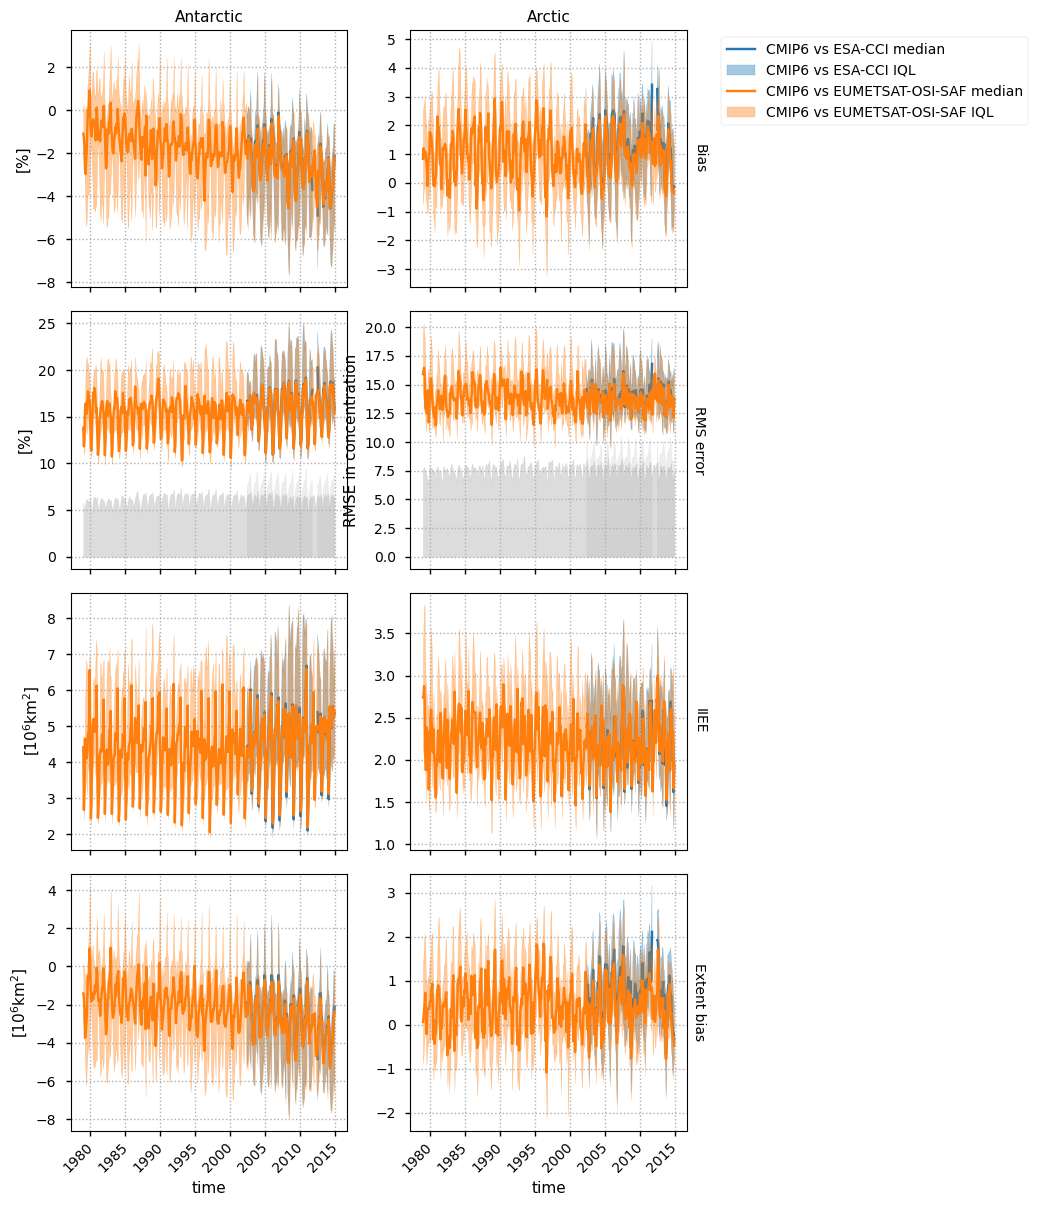

In [14]:
_ = plot_timeseries(ds_cmip6)

(climate_projections-cmip6_model-performance_q02:spatial-distribution)=
### Section D: Spatial distribution of errors
We compare 10-year-averaged maps from 1985-2015 which is roughly the overlap period between the historical experiment and the EUMETSAT OSI-SAF product. In the Arctic, the mean concentration is quite close to the mean from observations, but there is disagreement in the seas with seaonal ice - e.g. Greenland, Barents, Labrador, Bering and Okhotsk Seas and Hudson Bay, and (in the summer) off the Russian and Alaskan coasts. For the Antarctic there is systematic underestimation of concentration.

In [15]:
projections = {
    "Arctic" : ccrs.Stereographic(central_latitude=90.),
    "Antarctic" : ccrs.Stereographic(central_latitude=-90.),
}

# slices in x and y directions (on observation grid)
map_slices = {
    "Arctic": {'xc': slice(50, -100), 'yc': slice(50, -50)},
    "Antarctic": {'xc': slice(50, -50), 'yc': slice(50, -50)},
}

map_kwargs = {
    "datasets_eumetsat": datasets_eumetsat,
    "datasets_cmip6": datasets_cmip6,
    "projections": projections,
    "map_slices": map_slices,
}

(climate_projections-cmip6_model-performance_q02:arctic-min)=
#### Arctic minimum
Looking at the maps below for September, we can see there is a general underestimation in the pack ice and an overestimation in the MIZ and near the coasts. This pattern persists with time although the locations move as the Arctic ice cover shrinks with time. This may be a resolution effect, since roughly the same amount of ice (low bias in sea ice concentration) may just be being spread out over a larger area.

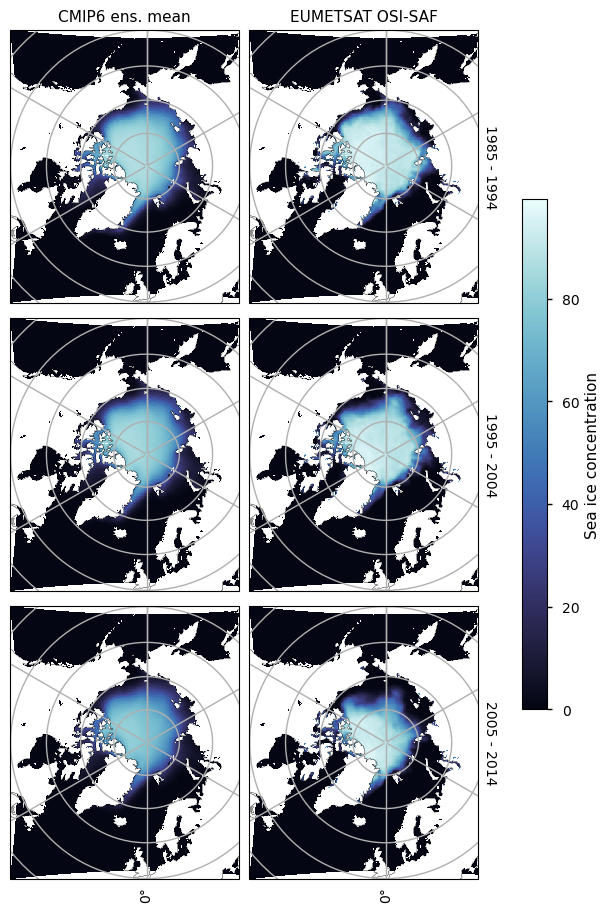

In [16]:
compare_sic_maps(region="Arctic", sel_dict={"month": "September"}, **map_kwargs)

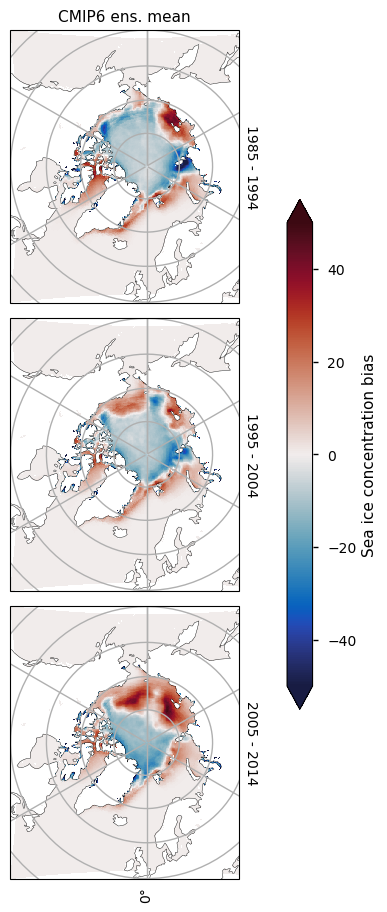

In [17]:
compare_sic_maps(region="Arctic", sel_dict={"month": "September"}, plot_func=make_sic_bias_maps, **map_kwargs)

(climate_projections-cmip6_model-performance_q02:arctic-max)=
#### Arctic maximum
Looking at the maps below for March, we can see the ice in the central Arctic is generally unbiased, but there are some areas where there is strong underestimation - the Bering Sea and the Sea of Okhotsk - and there is strong overestimation in the Greenland Sea and the North Atlantic Ocean near the entrance to Hudson Bay. Overall, the total ice area is roughly the same in CMIP6 and the satellite observations.

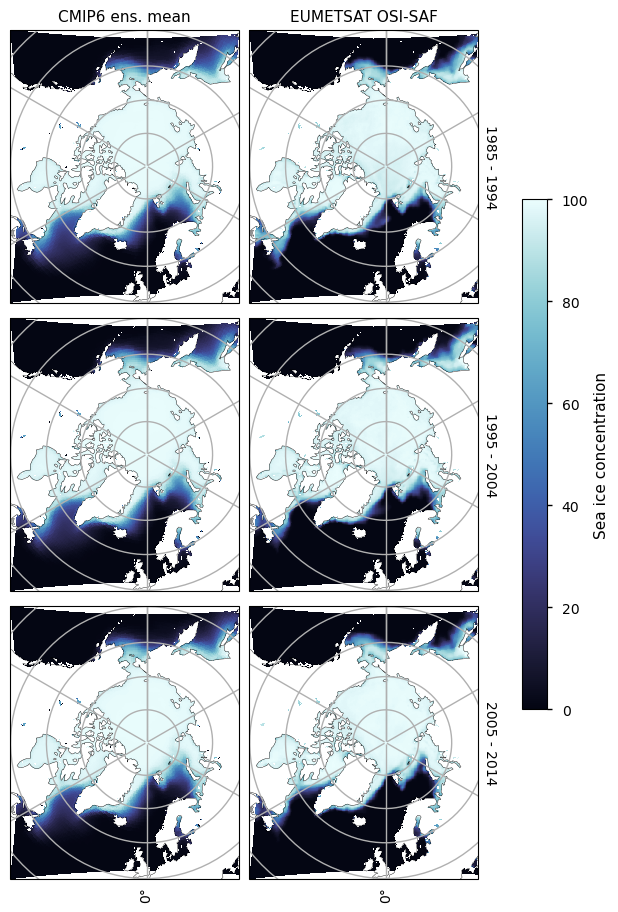

In [18]:
compare_sic_maps(region="Arctic", sel_dict={"month": "March"}, **map_kwargs)

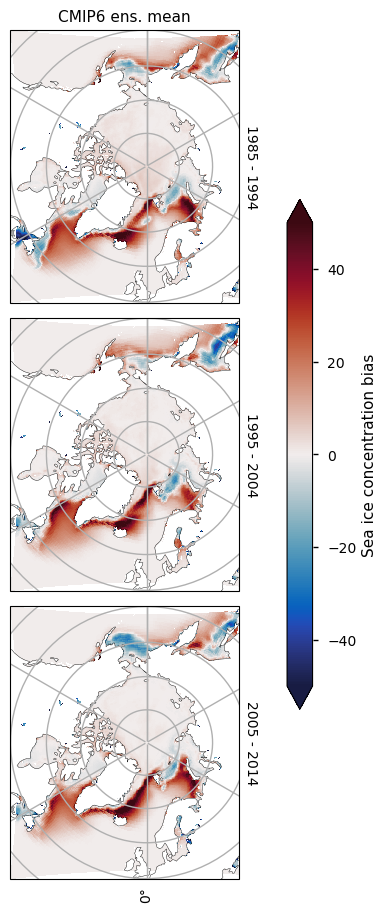

In [19]:
compare_sic_maps(region="Arctic", sel_dict={"month": "March"}, plot_func=make_sic_bias_maps, **map_kwargs)

(climate_projections-cmip6_model-performance_q02:antarctic-min)=
#### Antarctic minimum
There is consistently too little ice on the Atlantic side of Antarctica (in the Weddell, Bellingshausen and Amundsen Seas). The amount of sea ice in those areas is also decreasing with time, while the concentration from satellite is staying relatively constant. On the Pacific and Indian ocean sides there is more of a dipole pattern (too little at the coast and too much away from it), probably due to the effect of low resolution in the CMIP6 models.

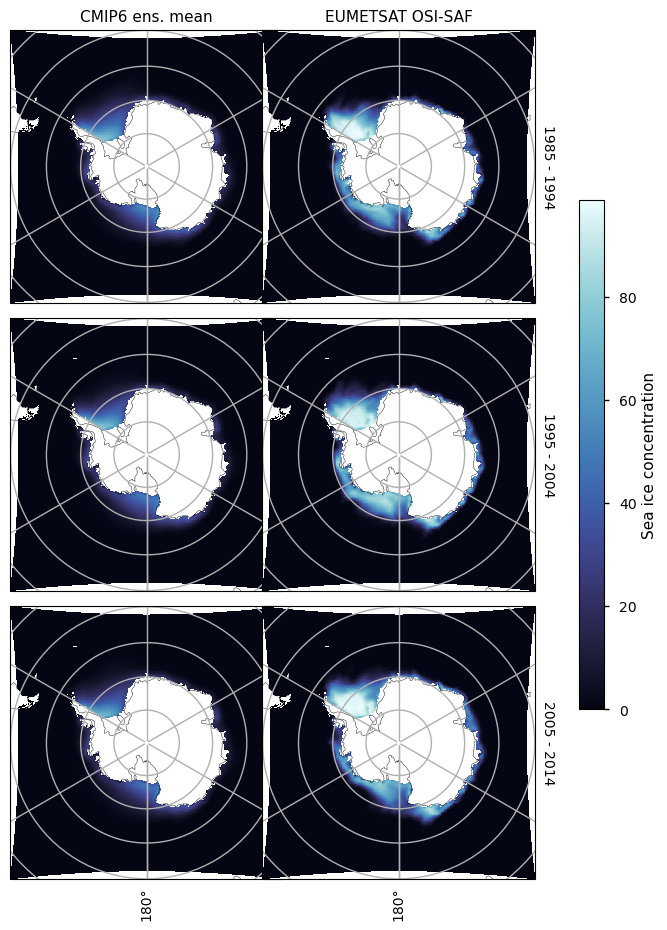

In [20]:
compare_sic_maps(region="Antarctic", sel_dict={"month": "March"}, **map_kwargs)

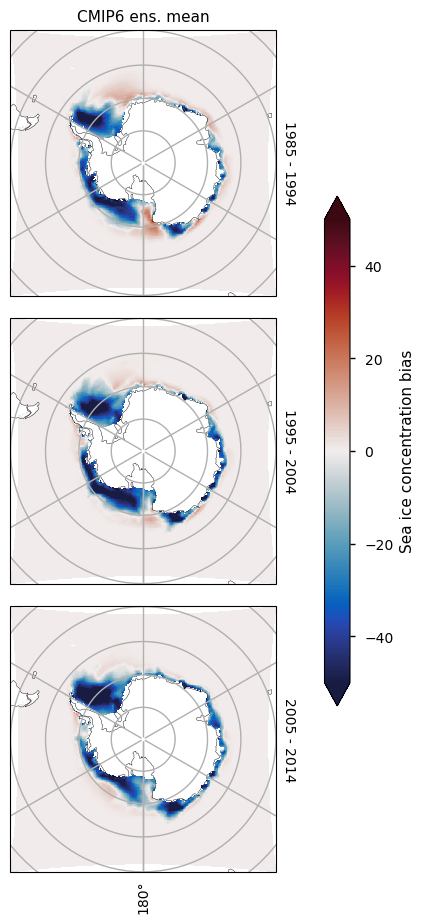

In [21]:
compare_sic_maps(region="Antarctic", sel_dict={"month": "March"}, plot_func=make_sic_bias_maps, **map_kwargs)

(climate_projections-cmip6_model-performance_q02:antarctic-max)=
#### Antarctic maximum
For the month of September there is in general too little ice everywhere, although away from the coast at longitude about 140$^\circ$W in the Atlantic Ocean, and in the Indian Ocean the underestimation is most pronounced. The underestimation on those areas is also increasing with time, while the concentration from satellite is staying relatively constant in this month as well.

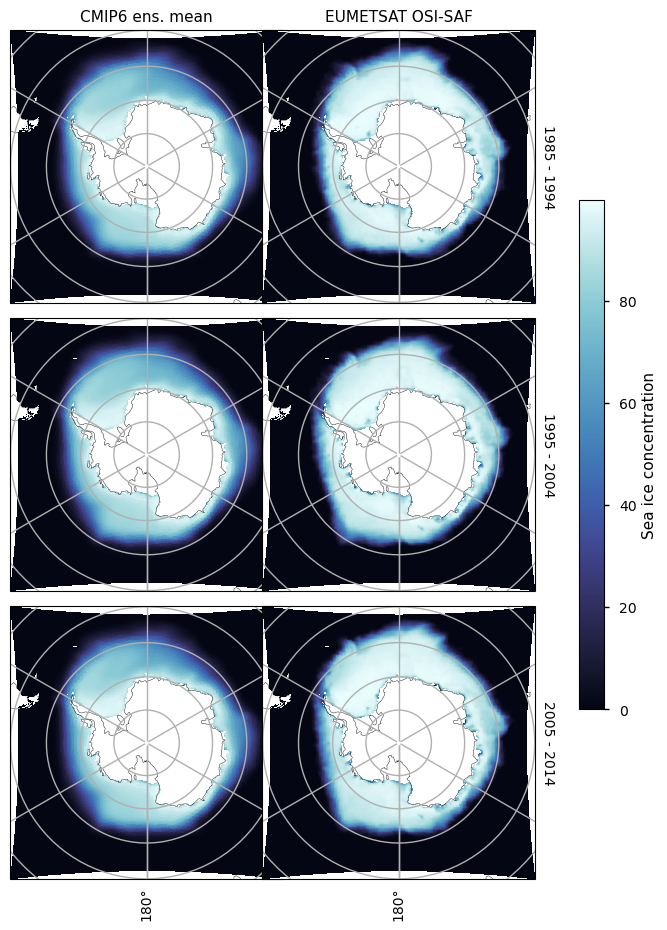

In [22]:
compare_sic_maps(region="Antarctic", sel_dict={"month": "September"}, **map_kwargs)

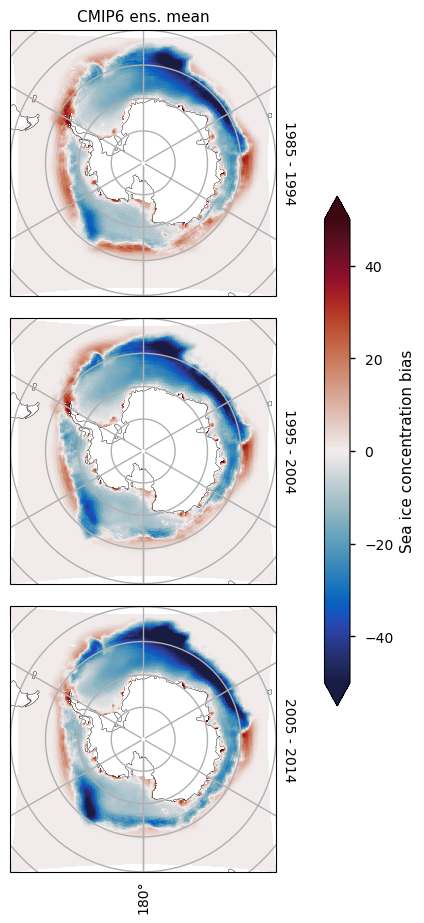

In [23]:
compare_sic_maps(region="Antarctic", sel_dict={"month": "September"},
                 plot_func=make_sic_bias_maps, **map_kwargs)

(climate_projections-cmip6_model-performance_q02:arctic-december)=
#### Arctic December (relevant to the Arctic shipping route assessment)
One of the other CMIP6 quality assessments looks at projections of accessibility of Arctic shipping routes, where sea ice in December is particularly interesting. Hence we also plot some maps for this month here. The CMIP6 ensemble mean is quite close to the satellite data in the Arctic Ocean, with the main feature of the bias maps being the underestimation in the Hudson Bay. Note that not all models that provide  sea ice concentration in the historical experiment also provide it in the different projection experiments, so that adds some additional uncertainty to these conclusions.

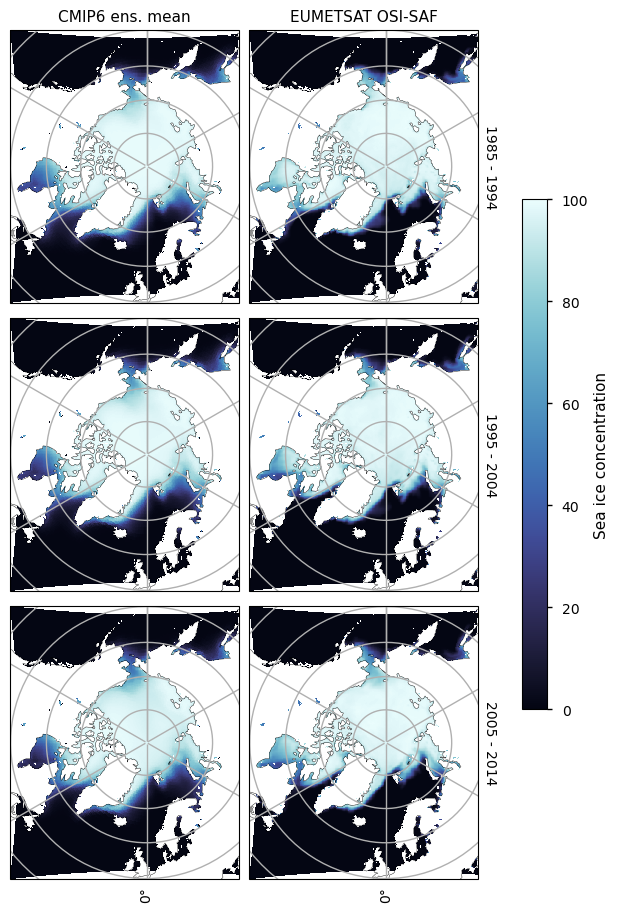

In [24]:
compare_sic_maps(region="Arctic", sel_dict={"month": "December"}, **map_kwargs)

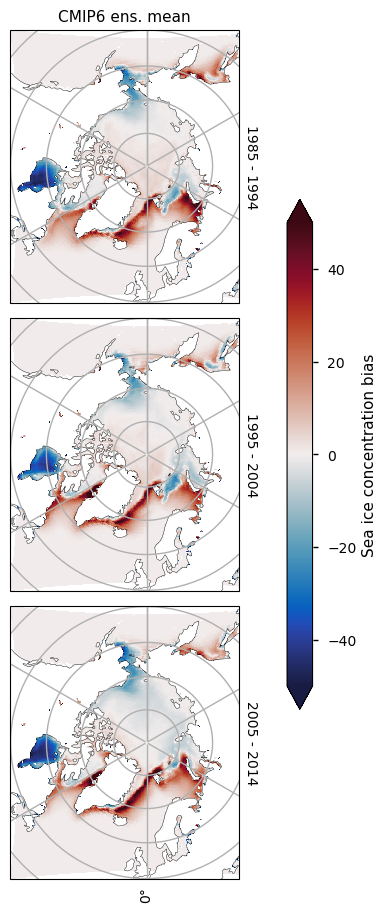

In [25]:
compare_sic_maps(region="Arctic", sel_dict={"month": "December"},
                 plot_func=make_sic_bias_maps, **map_kwargs)

## If you want to know more

### Key resources
Introductory sea ice materials:
- [Role of sea ice in the climate](https://www.epa.gov/climate-indicators/climate-change-indicators-arctic-sea-ice)
- [Observing sea ice with satellites](https://www.metoffice.gov.uk/research/climate/cryosphere-oceans/sea-ice/measure)

Introductory CMIP6 materials:
- [A short introduction to CMIP and CMIP6](https://www.wcrp-climate.org/wgcm-cmip/cmip-video)
- [CMIP6: the next generation of climate models explained](https://www.carbonbrief.org/cmip6-the-next-generation-of-climate-models-explained/)

Code libraries used:
- [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control) developed by [B-Open](https://www.bopen.eu/)

### References

1. Davy, R., and S. Outten (2020). The Arctic Surface Climate in CMIP6: Status and Developments since CMIP5. J. Climate, 33, 8047–8068, https://doi.org/10.1175/JCLI-D-19-0990.1.

2. Frankignoul, C., L. Raillard, B. Ferster, and Y. Kwon (2024). Arctic September sea ice concentration biases in CMIP6 models and their relationships with other model variables. J. Climate, https://doi.org/10.1175/JCLI-D-23-0452.1, in press.

3. Goessling, H. F., S. Tietsche, J. J. Day, E. Hawkins, and T. Jung (2016). Predictability of the Arctic sea ice edge, Geophys. Res. Lett., 43, 1642–1650, https://doi.org/10.1002/2015GL067232.

4. Henke, M., F. Cassalho, T. Miesse, C. M. Ferreira, J. Zhang and T. M. Ravens (2023). Assessment of Arctic sea ice and surface climate conditions in nine CMIP6 climate models. Arctic, Antarctic, and Alpine Research, 55(1). https://doi.org/10.1080/15230430.2023.2271592

5. Nie, Y., X. Lin,  Q. Yang, J. Liu, D. Chen and P. Uotila (2023). Differences between the CMIP5 and CMIP6 Antarctic sea ice concentration budgets. Geophysical Research Letters, 50, e2023GL105265. https://doi.org/10.1029/2023GL105265

6. Li, S., Y. Zhang, C. Chen, Y. Zhang, D. Xu, and S. Hu (2023). Assessment of Antarctic Sea Ice Cover in CMIP6 Prediction with Comparison to AMSR2 during 2015–2021. Remote Sensing 15(8): 2048. https://doi.org/10.3390/rs15082048.

7. Roach, L. A., J. Dörr, C. R. Holmes, F. Massonnet, E. W. Blockley, D. Notz, T. Rackow, M. N. Raphael, S. P. O'Farrell, D. A. Bailey, and C. M. Bitz (2020). Antarctic sea ice area in CMIP6. Geophysical Research Letters, 47, e2019GL086729. https://doi.org/10.1029/2019GL086729

8. Shu, Q., Q. Wang, Z. Song, F. Qiao, J. Zhao, M. Chu and X. Li (2020). Assessment of sea ice extent in CMIP6 with comparison to observations and CMIP5. Geophysical Research Letters, 47, e2020GL087965, https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2020GL087965

9. SIMIP Community (2020). Arctic sea ice in CMIP6. Geophysical Research Letters, 47, e2019GL086749. https://doi.org/10.1029/2019GL086749

10. Watts, M., W. Maslowski, Y. J. Lee, J. C. Kinney, and R. Osinski (2021). A Spatial Evaluation of Arctic Sea Ice and Regional Limitations in CMIP6 Historical Simulations. J. Climate, 34, 6399–6420, https://doi.org/10.1175/JCLI-D-20-0491.1.